# Chemical reactions figure

In [10]:
%load_ext autoreload
%autoreload 2
import json
import zipfile
import pandas as pd
from tqdm.auto import tqdm
from io import TextIOWrapper
from collections import defaultdict

measure = 'sigma'
trial_indices = defaultdict(int)
records = []
path = '../../dgym-data/analysis/noise/selection_noise_2024-05-10_23-36-56_continued.zip'
with zipfile.ZipFile(path, 'r') as z:
    for filename in tqdm(z.namelist()):
        with z.open(filename) as file:
            with TextIOWrapper(file, encoding='utf-8') as text_file:
                result = json.load(text_file)
                
                # Get annotations
                record = pd.DataFrame(result['annotations']).reindex(
                    columns=[
                        'SMILES',
                        'Inspiration',
                        'Current Status',
                        'ABL1 pIC50',
                        'Log P',
                        'Log S',
                        'Noisy ABL1 pIC50',
                        'Noisy Log P',
                        'Noisy Log S',
                        'Step Tested',
                        'Step Scored',
                        'Synthetic Route',
                    ]
                )
                
                # Get trial number
                value = result[measure]
                trial_indices[value] += 1
                record[measure] = value
                record['trial'] = trial_indices[value]

                # Append
                records.append(record)
df = pd.concat(records)
records = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
from dgym.envs.utility import MultipleUtilityFunction, ClassicUtilityFunction

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    ideal=(9, 13),
    acceptable=(8, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(-0.5, 3.5),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-4, 1),
    acceptable=(-4, 1)
)

composite_utility_function = MultipleUtilityFunction(
    utility_functions = [docking_utility_function, log_P_utility_function, log_S_utility_function],
    weights = [0.8, 0.1, 0.1]
)

df['utility'] = composite_utility_function(
    df[['ABL1 pIC50', 'Log P', 'Log S']].values,
    precompute=True,
    method='average'
)

Collecting reactions associated with the best molecules and the background distribution.

In [12]:
import dgym as dg

reactions = dg.ReactionCollection.from_json(
    path = f'../../dgym-data/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

In [13]:
import re

def get_reactions(df):
    reaction_sets = []
    for route in df['Synthetic Route']:
        route = str(route)
        match = re.findall(r"'reaction':\s*'([^']+)'", route)
        reaction_sets.append(match)
    return reaction_sets

background_reactions = get_reactions(df.query('`Step Scored` == 0.0')) # starting hits
top_reactions = get_reactions(df.query('utility >= 1.0'))

In [14]:
from collections import defaultdict

reaction_usage = []
for reaction in reactions:
    
    # Start count
    top_usage = 0
    background_usage = 0
    
    # Compute usage
    for reaction_set in top_reactions:
        if reaction.name in reaction_set:
            top_usage += 1
    for reaction_set in background_reactions:
        if reaction.name in reaction_set:
            background_usage += 1        
    
    # Append record
    reaction_usage.append({
        'reaction': reaction.name,
        'usage': top_usage,
        'background': background_usage
    })

reaction_usage = pd.DataFrame(reaction_usage)

In [15]:
reaction_usage['usage_frequency'] = \
    reaction_usage['usage'] / reaction_usage['usage'].sum()
reaction_usage['background_frequency'] = \
    reaction_usage['background'] / reaction_usage['background'].sum()

Compare relative frequencies.

In [16]:
import pandas as pd

reaction_compatibility = pd.read_csv('../../dgym-data/reaction_compatibility_10000.csv', index_col=0)
reaction_compatibility['frequency'] = \
    reaction_compatibility['num_compatible'] / reaction_compatibility['num_compatible'].sum()

reaction_stats = reaction_compatibility.merge(reaction_usage, on='reaction')
reaction_stats['usage_frequency'] = reaction_stats['usage'] / reaction_stats['usage'].sum()
reaction_stats = reaction_stats.sort_values('frequency', ascending=False)
reaction_stats = reaction_stats.rename(columns={
    'reaction': 'Reaction',
    'usage_frequency': 'In-Use Frequency',
    'background_frequency': 'Background Frequency',
    'frequency': 'Enamine REAL Compatibility',
})

reaction_stats['Reaction'] = (
    reaction_stats['Reaction']
    .str.replace(r'^\d+_', '', regex=True)
    .str.replace('_', ' ')
)

In [17]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5), dpi=300)
# sns.set()
# colors = sns.color_palette('magma', 4)
# g = sns.pointplot(reaction_stats.iloc[:20], x='Reaction', y='Background Frequency', color=colors[1])
# g = sns.pointplot(reaction_stats.iloc[:20], x='Reaction', y='In-Use Frequency', color=colors[-1])
# plt.xticks(rotation=90)

Inspired by https://stats.stackexchange.com/questions/423735/what-is-the-name-of-this-plot-that-has-rows-with-two-connected-dots.

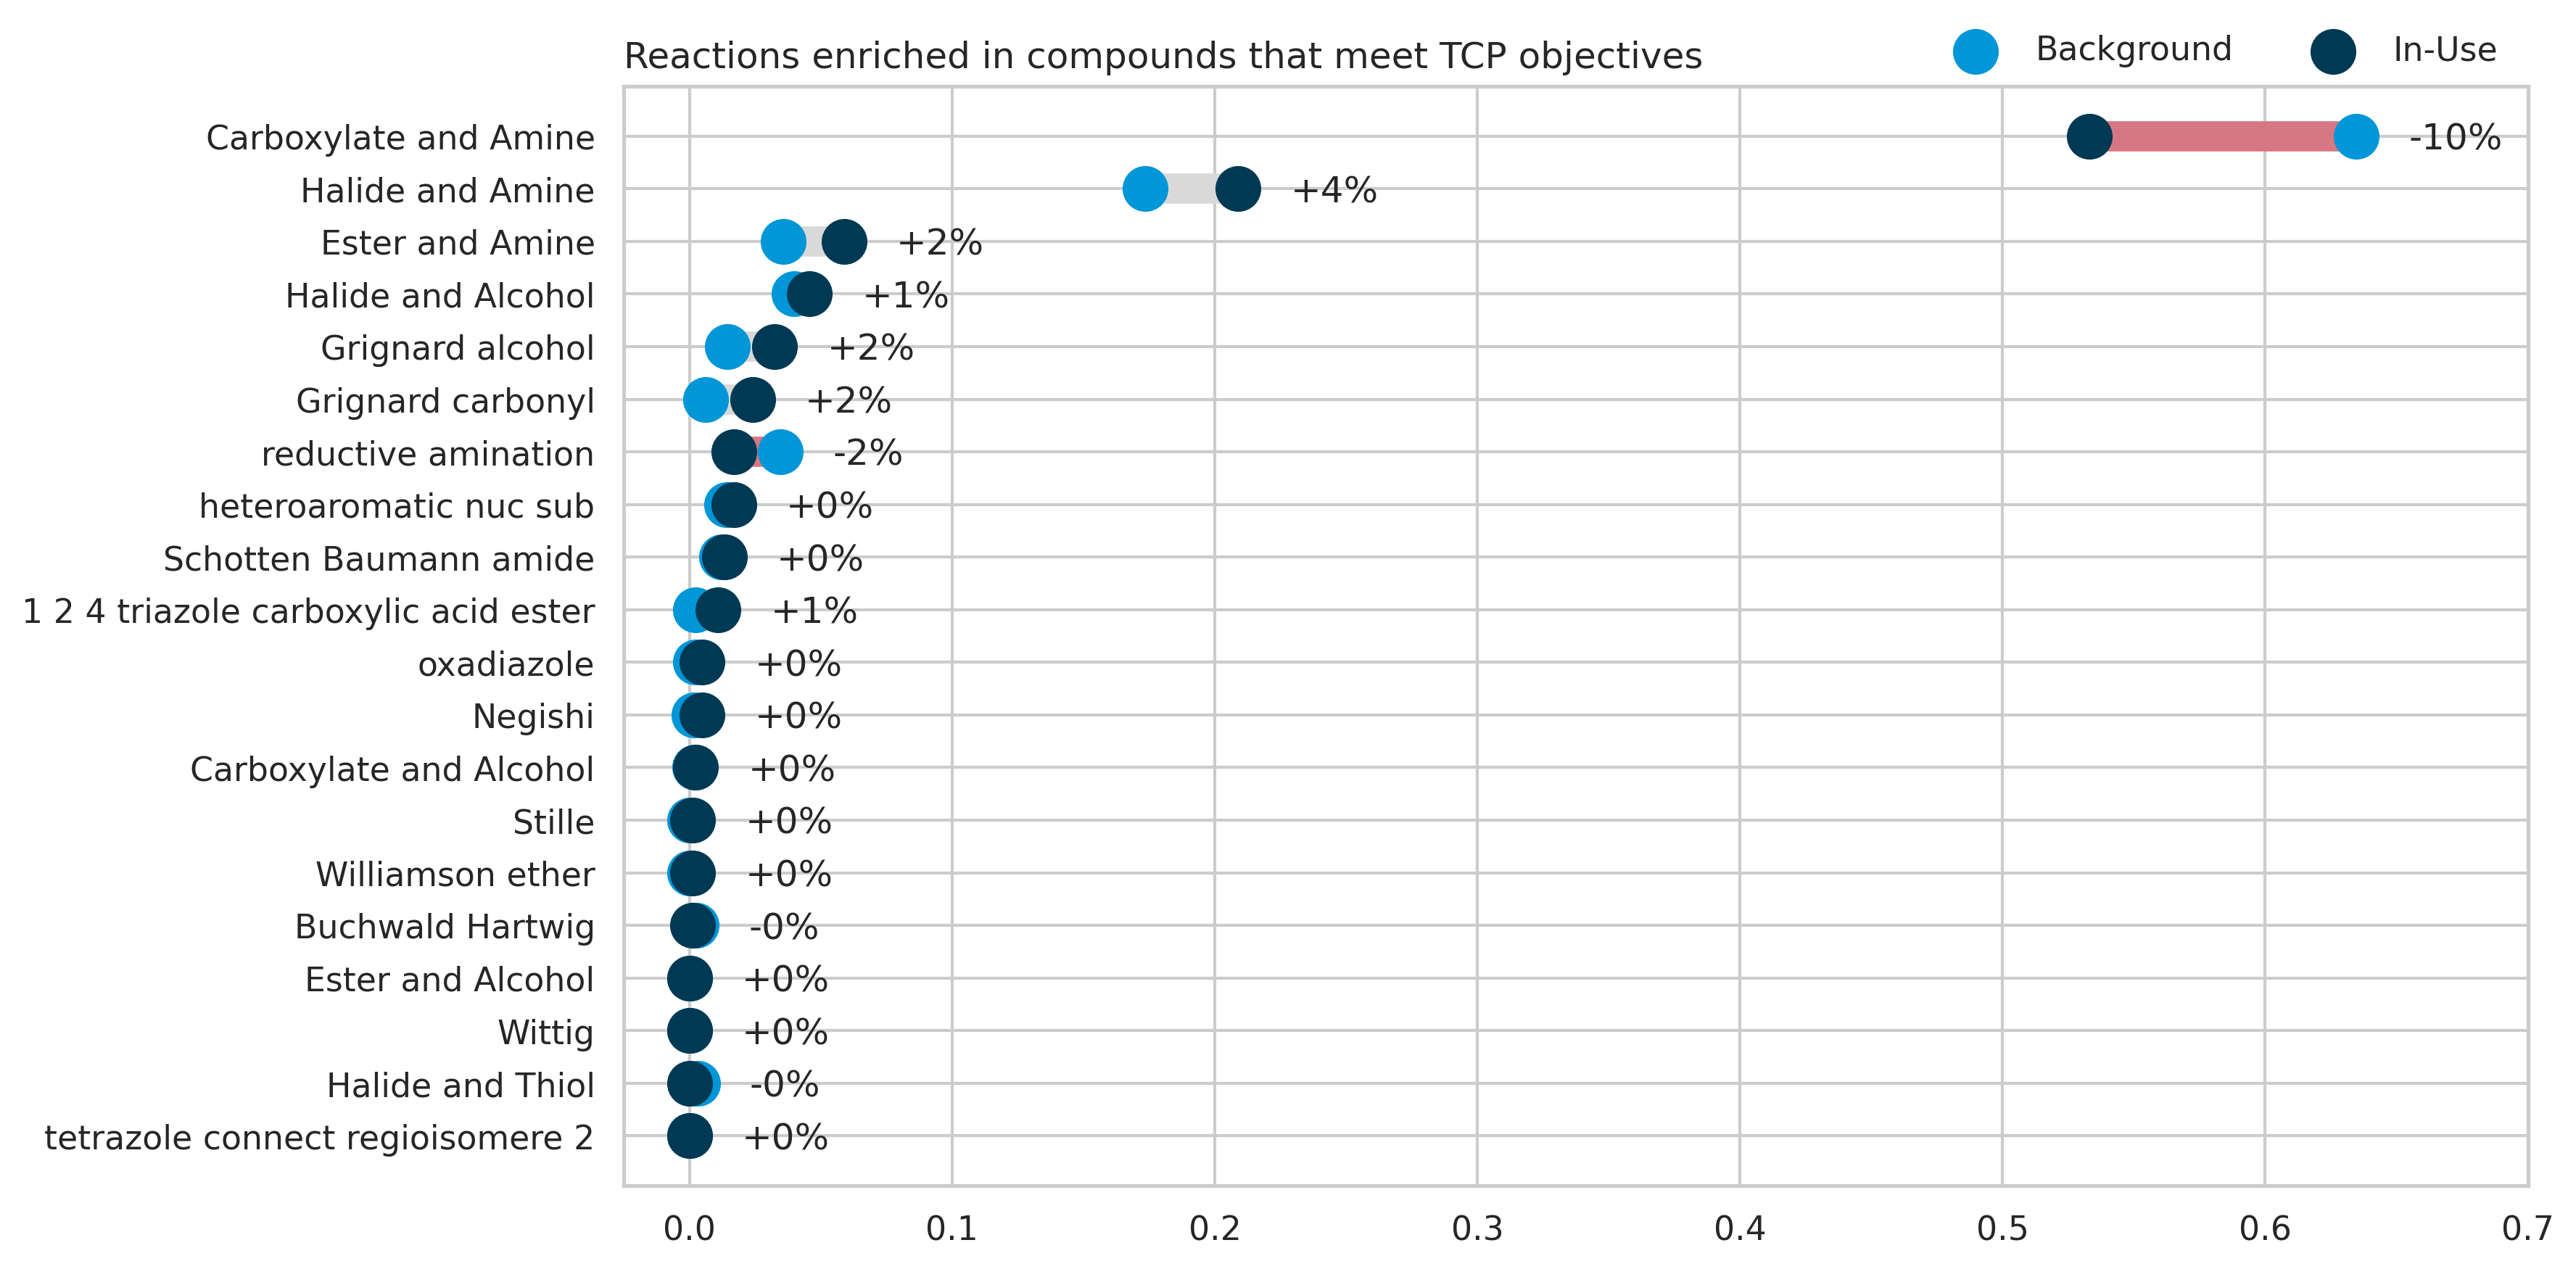

In [18]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")  # set style
df_ = (
    reaction_stats
    .iloc[:20]
    .set_index("Reaction")
    .sort_values("In-Use Frequency", ascending=True)
)

plt.figure(figsize=(12, 6), dpi=300)
y_range = np.arange(1, len(df_.index) + 1)

background = 'Background Frequency'
df_['change'] = df_['In-Use Frequency'] - df_[background]
colors = np.where(df_['In-Use Frequency'] > df_[background], '#d9d9d9', '#d57883')
plt.hlines(y=y_range, xmin=df_[background], xmax=df_['In-Use Frequency'],
           color=colors, lw=10)
plt.scatter(df_[background], y_range, color='#0096d7', s=200, label='Background', zorder=3)
plt.scatter(df_['In-Use Frequency'], y_range, color='#003953', s=200 , label='In-Use', zorder=3)
for (_, row), y in zip(df_.iterrows(), y_range):
    plt.annotate(
        f"{row['change']:+.0%}",
        (max(row[background], row["In-Use Frequency"]) + 0.02, y - 0.25)
    )
plt.legend(ncol=2, bbox_to_anchor=(1., 0.99), loc="lower right", frameon=False)

plt.yticks(y_range, df_.index)
plt.title("Reactions enriched in compounds that meet TCP objectives", loc='left')
plt.xlim(-0.025, 0.7)
plt.gcf().subplots_adjust(left=0.35)
plt.tight_layout()
plt.show()